# 3-1，低阶API示范

In [1]:
import tensorflow as tf

#打印时间分割线
@tf.function
def printbar():
    today_ts = tf.timestamp()%(24*60*60)

    hour = tf.cast(today_ts//3600+8,tf.int32)%tf.constant(24)
    minite = tf.cast((today_ts%3600)//60,tf.int32)
    second = tf.cast(tf.floor(today_ts%60),tf.int32)
    
    def timeformat(m):
        if tf.strings.length(tf.strings.format("{}",m))==1:
            return(tf.strings.format("0{}",m))
        else:
            return(tf.strings.format("{}",m))
    
    timestring = tf.strings.join([timeformat(hour),timeformat(minite),
                timeformat(second)],separator = ":")
    tf.print("=========="*8+timestring)

## 一，线性回归模型
### 1，准备数据

In [2]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
import tensorflow as tf 

n = 400

X = tf.random.uniform([n,2], minval=-10, maxval=10)
w0 = tf.constant([[2.0], [-3.0]])
b0 = tf.constant([[3.0]])
Y = X@w0 + b0 + tf.random.normal([n,1], mean=0.0, stddev=2.0)

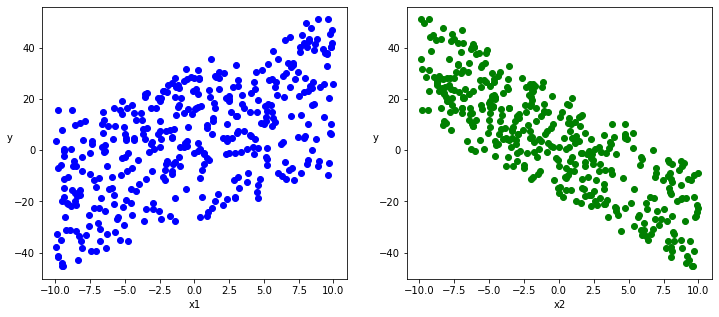

In [3]:
plt.figure(figsize=(12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:, 0], Y[:], c='b')
plt.xlabel("x1")
plt.ylabel('y', rotation=0)

ax2 = plt.subplot(122)
ax2.scatter(X[:, 1], Y[:], c='g')
plt.xlabel('x2')
plt.ylabel('y', rotation=0)

plt.show()

In [4]:
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        indexs = indices[i: min(i+batch_size, num_examples)]
        yield tf.gather(features, indexs), tf.gather(labels, indexs)

In [5]:
batch_size = 8
(features, labels) = next(data_iter(X, Y, batch_size))
features, labels

(<tf.Tensor: shape=(8, 2), dtype=float32, numpy=
 array([[-9.9502945 , -6.5358925 ],
        [ 3.3716602 ,  3.0055857 ],
        [ 4.2968655 ,  4.1198845 ],
        [ 5.5786915 ,  1.5162201 ],
        [ 0.21993446, -6.39009   ],
        [-7.2037935 , -0.32126427],
        [-9.094515  ,  3.2167578 ],
        [-4.8364544 ,  0.8165455 ]], dtype=float32)>,
 <tf.Tensor: shape=(8, 1), dtype=float32, numpy=
 array([[  3.5065105 ],
        [ -0.87712705],
        [ -1.4044695 ],
        [  9.369628  ],
        [ 21.990524  ],
        [-11.486323  ],
        [-21.205442  ],
        [ -8.019949  ]], dtype=float32)>)

### 3，定义模型

In [6]:
w = tf.Variable(tf.random.normal(w0.shape))
b = tf.Variable(tf.zeros_like(b0,dtype = tf.float32))

# 定义模型
class LinearRegression:     
    #正向传播
    def __call__(self,x): 
        return x@w + b

    # 损失函数
    def loss_func(self,y_true,y_pred):  
        return tf.reduce_mean((y_true - y_pred)**2/2)

model = LinearRegression()

### 4，训练模型

In [7]:
# 使用动态图调试
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(labels, predictions)
    # 反向传播求梯度
    dloss_dw,dloss_db = tape.gradient(loss,[w,b])
    # 梯度下降法更新参数
    w.assign(w - 0.001*dloss_dw)
    b.assign(b - 0.001*dloss_db)
    
    return loss

In [8]:
batch_size = 10
(features, labels) = next(data_iter(X, Y, batch_size))
train_step(model, features, labels)

<tf.Tensor: shape=(), dtype=float32, numpy=105.33086>

In [9]:
def train_model(model, epochs, batch_size):
    for epoch in range(epochs):
        for features, labels in data_iter(X, Y, batch_size):
            loss = train_step(model, features, labels)

        if (epoch+1)%50 == 0:
            printbar()
            tf.print("epoch =", epoch+1, " loss =", loss)
            tf.print("w =", w)
            tf.print("b =", b)

train_model(model, 200, 10)

================================================================================17:36:46
epoch = 50  loss = 1.11782074
w = [[1.96843421]
 [-3.01075315]]
b = [[2.53122425]]
================================================================================17:36:53
epoch = 100  loss = 2.2836864
w = [[1.97067153]
 [-3.00312567]]
b = [[2.86931562]]
================================================================================17:37:01
epoch = 150  loss = 0.999498844
w = [[1.96623814]
 [-3.00131822]]
b = [[2.91576433]]
================================================================================17:37:08
epoch = 200  loss = 2.5679462
w = [[1.97006464]
 [-3.00649405]]
b = [[2.92210102]]


In [10]:
@tf.function
def train_step(model, features, labels, learning_rate):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(labels, predictions)

    dloss_dw, dloss_db = tape.gradient(loss, [w, b])
    
    w.assign(w - learning_rate*dloss_dw)
    b.assign(b - learning_rate*dloss_db)

    return loss

In [11]:
def train_model(model,epochs, learning_rate, batch_size):
    for epoch in tf.range(1,epochs+1):
        for features, labels in data_iter(X,Y,batch_size):
            loss = train_step(model,features,labels, learning_rate)
        if epoch%50==0:
            printbar()
            tf.print("epoch =",epoch,"loss = ",loss)
            tf.print("w =",w)
            tf.print("b =",b)

train_model(model,epochs = 200, learning_rate=0.001, batch_size=10)

================================================================================17:37:10
epoch = 50 loss =  1.04466486
w = [[1.97183955]
 [-3.00398445]]
b = [[2.92366886]]
================================================================================17:37:11
epoch = 100 loss =  1.22954714
w = [[1.9732703]
 [-3.00475931]]
b = [[2.92288208]]
================================================================================17:37:13
epoch = 150 loss =  1.9571507
w = [[1.97653115]
 [-2.99983311]]
b = [[2.92373657]]
================================================================================17:37:14
epoch = 200 loss =  1.62945879
w = [[1.97761595]
 [-2.99797058]]
b = [[2.92301083]]


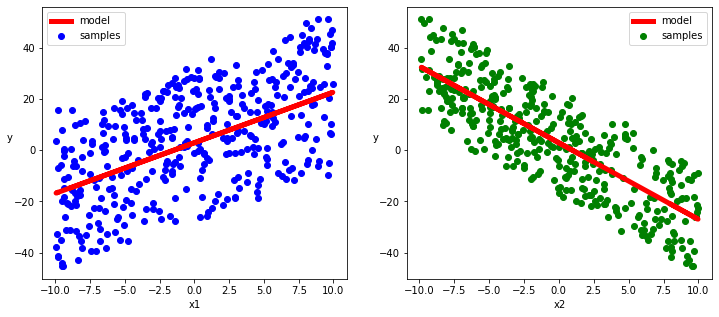

In [12]:
plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.plot(X[:,0],w[0]*X[:,0]+b[0],"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)


ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.plot(X[:,1],w[1]*X[:,1]+b[0],"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)

plt.show()

## 二，DNN二分类模型
### 1，准备数据

In [13]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import tensorflow as tf

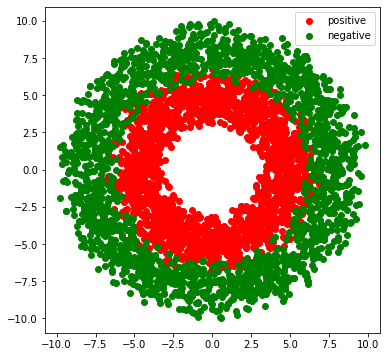

In [14]:
#正负样本数量
n_positive,n_negative = 2000,2000

#生成正样本, 小圆环分布
r_p = 5.0 + tf.random.truncated_normal([n_positive,1],0.0,1.0)
theta_p = tf.random.uniform([n_positive,1],0.0,2*np.pi) 
Xp = tf.concat([r_p*tf.cos(theta_p),r_p*tf.sin(theta_p)],axis = 1)
Yp = tf.ones_like(r_p)

#生成负样本, 大圆环分布
r_n = 8.0 + tf.random.truncated_normal([n_negative,1],0.0,1.0)
theta_n = tf.random.uniform([n_negative,1],0.0,2*np.pi) 
Xn = tf.concat([r_n*tf.cos(theta_n),r_n*tf.sin(theta_n)],axis = 1)
Yn = tf.zeros_like(r_n)

#汇总样本
X = tf.concat([Xp,Xn],axis = 0)
Y = tf.concat([Yp,Yn],axis = 0)


#可视化
plt.figure(figsize = (6,6))
plt.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
plt.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
plt.legend(["positive","negative"]);

In [15]:
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    index = np.random.shuffle(indices)

    for i in range(0, num_examples, batch_size):
        indexs = indices[i: min(i+batch_size, num_examples)]
        yield tf.gather(features, indexs), tf.gather(labels, indexs)

batch_size = 10
features, labels = next(data_iter(X, Y, batch_size))
features, labels

(<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
 array([[ 7.1240873, -5.9771786],
        [ 1.5425347, -3.3829968],
        [ 1.221268 ,  3.535574 ],
        [ 2.2518063,  7.9335685],
        [ 1.5092566, -8.418275 ],
        [-4.85986  , -1.8191165],
        [-5.314502 ,  1.5539502],
        [-4.8524623, -7.8536806],
        [-6.0940742, -2.128272 ],
        [ 5.1275744,  3.3746495]], dtype=float32)>,
 <tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.]], dtype=float32)>)

### 2，定义模型

In [53]:
class DNNModel(tf.Module):
    def __init__(self, name = None):
        super(DNNModel, self).__init__(name=name)
        self.w1 = tf.Variable(tf.random.truncated_normal([2,4]),dtype = tf.float32)
        self.b1 = tf.Variable(tf.zeros([1,4]),dtype = tf.float32)
        self.w2 = tf.Variable(tf.random.truncated_normal([4,8]),dtype = tf.float32)
        self.b2 = tf.Variable(tf.zeros([1,8]),dtype = tf.float32)
        self.w3 = tf.Variable(tf.random.truncated_normal([8,1]),dtype = tf.float32)
        self.b3 = tf.Variable(tf.zeros([1,1]),dtype = tf.float32)

    # 正向传播
    @tf.function
    def __call__(self,x):
        x = tf.nn.relu(x@self.w1 + self.b1)
        x = tf.nn.relu(x@self.w2 + self.b2)
        y = tf.nn.sigmoid(x@self.w3 + self.b3)
        return y

    # 损失函数(二元交叉熵)
    @tf.function
    def loss_func(self,y_true,y_pred):  
        #将预测值限制在 1e-7 以上, 1 - 1e-7 以下，避免log(0)错误
        eps = 1e-7
        y_pred = tf.clip_by_value(y_pred,eps,1.0-eps)
        bce = - y_true*tf.math.log(y_pred) - (1-y_true)*tf.math.log(1-y_pred)
        return  tf.reduce_mean(bce)

    # 评估指标(准确率)
    @tf.function
    def metric_func(self, y_true, y_pred):
        y_pred = tf.where(y_pred>0.5, tf.ones_like(y_pred), tf.zeros_like(y_pred))
        acc = tf.reduce_mean(1-tf.abs(y_true-y_pred))
        return acc

model = DNNModel()

In [54]:
batch_size = 10
(features, labels) = next(data_iter(X,Y,batch_size))

predictions = model(features)

loss = model.loss_func(labels, predictions)
metric = model.metric_func(labels, predictions)

loss, metric

(<tf.Tensor: shape=(), dtype=float32, numpy=1.8654407>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.7>)

### 3，训练模型

In [64]:
@tf.function
def train_step(model, features, labels, batch_size, learning_rate):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(labels, predictions)
    
    grads = tape.gradient(loss, model.trainable_variables)

    for p, dloos_dp in zip(model.trainable_variables, grads):
        p.assign(p - learning_rate*dloos_dp)

    metric = model.metric_func(labels, predictions)

    return loss, metric

def train_model(model, epochs, batch_size, learning_rate):
    for epoch in range(epochs):
        for features, labels in data_iter(X, Y, batch_size):
           # print(learning_rate)
            loss, metric = train_step(model, features, labels, batch_size, learning_rate)

        if (epoch + 1)%50 == 0:
            printbar()
            tf.print("epoch =", epoch+1, " loss =", loss, " accuracy =", metric)

In [65]:
batch_size = 10
epochs = 600
learning_rate = 0.001

train_model(model, epochs, batch_size, learning_rate)

================================================================================18:04:33
epoch = 50  loss = 0.182415053  accuracy = 0.9
================================================================================18:04:53
epoch = 100  loss = 0.0944530368  accuracy = 0.9
================================================================================18:05:14
epoch = 150  loss = 0.0167070813  accuracy = 1
================================================================================18:05:34
epoch = 200  loss = 0.658583283  accuracy = 0.8
================================================================================18:05:54
epoch = 250  loss = 0.182370886  accuracy = 0.9
================================================================================18:06:14
epoch = 300  loss = 0.0261791758  accuracy = 1
================================================================================18:06:35
epoch = 350  loss = 0.0216437019  accuracy = 1
============================================

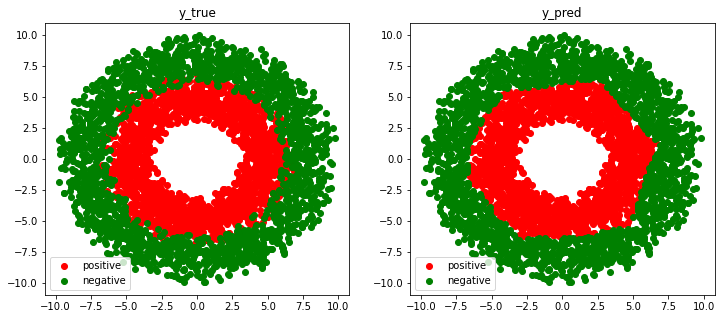

In [66]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:,0],Xp[:,1],c = "r")
ax1.scatter(Xn[:,0],Xn[:,1],c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true");

Xp_pred = tf.boolean_mask(X,tf.squeeze(model(X)>=0.5),axis = 0)
Xn_pred = tf.boolean_mask(X,tf.squeeze(model(X)<0.5),axis = 0)

ax2.scatter(Xp_pred[:,0],Xp_pred[:,1],c = "r")
ax2.scatter(Xn_pred[:,0],Xn_pred[:,1],c = "g")
ax2.legend(["positive","negative"]);
ax2.set_title("y_pred");